This notebook demonstrates use of our linear approximation for a multiplicative functional perturbation 

In [1]:
import jax
from jax import numpy as np
from jax import scipy as sp

from numpy.polynomial.hermite import hermgauss

import paragami

# BNP sensitivity libraries
import bnpgmm_runjingdev.gmm_clustering_lib as gmm_lib
import bnpgmm_runjingdev.gmm_cavi_lib as cavi_lib
from bnpgmm_runjingdev import utils_lib
from bnpgmm_runjingdev import gmm_stick_influence_lib as gmm_influence_lib

from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation
import bnpmodeling_runjingdev.functional_sensitivity_lib as func_sens_lib 
from bnpmodeling_runjingdev import cluster_quantities_lib as cluster_lib

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA

from copy import deepcopy

import vittles
from tqdm import tqdm

import json 

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
# colors for plotting
import matplotlib.cm as cm

cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(12)]
colors2 = [cmap(k * 25) for k in range(12)]

# Load data

We load and plot the iris dataset

In [3]:
# load iris data
dataset_name = 'iris'
features, iris_species = utils_lib.load_data()
dim = features.shape[1]
n_obs = len(iris_species)    

Text(0, 0.5, 'PC2')

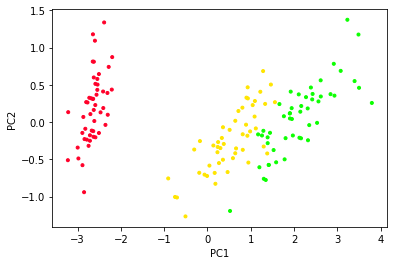

In [4]:
# run PCA
pca_fit = PCA()
pca_fit.fit(features)
pc_features = pca_fit.transform(features)

# plot
cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(30)]

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')


# Load model

### Get prior 

In [5]:
prior_params_dict, prior_params_paragami = gmm_lib.get_default_prior_params(dim)

In [6]:
print(prior_params_dict)

{'alpha': DeviceArray([3.], dtype=float64), 'prior_centroid_mean': DeviceArray([0.], dtype=float64), 'prior_lambda': DeviceArray([1.], dtype=float64), 'prior_wishart_df': DeviceArray([10.], dtype=float64), 'prior_wishart_rate': DeviceArray([[1., 0., 0., 0.],
             [0., 1., 0., 0.],
             [0., 0., 1., 0.],
             [0., 0., 0., 1.]], dtype=float64)}


### Variational parameters

In [7]:
k_approx = 30

In [8]:
# Gauss-Hermite points
gh_deg = 20
gh_loc, gh_weights = hermgauss(gh_deg)


In [11]:
# get vb parameters
vb_params_dict, vb_params_paragami = gmm_lib.get_vb_params_paragami_object(dim, k_approx)

print(vb_params_paragami)

OrderedDict:
	[cluster_params] = OrderedDict:
	[centroids] = NumericArrayPattern (4, 30) (lb=-inf, ub=inf)
	[cluster_info] = PatternArray (30,) of PDMatrix 4x4 (diag_lb = 0.0)
	[stick_params] = OrderedDict:
	[stick_means] = NumericArrayPattern (29,) (lb=-inf, ub=inf)
	[stick_infos] = NumericArrayPattern (29,) (lb=0.0001, ub=inf)


In [12]:
# the objective 
gmm_lib.get_kl(features, vb_params_dict, prior_params_dict, gh_loc, gh_weights)

DeviceArray(1624.52171584, dtype=float64)

# Optimize

### Kmeans

In [13]:
n_kmeans_init = 50
init_vb_free_params, init_vb_params_dict, init_ez = \
    utils_lib.cluster_and_get_k_means_inits(features, vb_params_paragami, 
                                                n_kmeans_init = n_kmeans_init, 
                                                seed = 2391)
                                                # seed = 32423)

### Run CAVI

In [14]:
vb_params_dict = deepcopy(init_vb_params_dict)

In [15]:
vb_opt_dict, e_z_opt = cavi_lib.run_cavi(features, vb_params_dict,
                                            vb_params_paragami, prior_params_dict,
                                            gh_loc, gh_weights,
                                            debug = False, 
                                            x_tol = 1e-3)

Compiling CAVI update functions ... 
CAVI compile time: 7.16sec

Running CAVI ... 
done. num iterations = 83
stick_time: 1.23sec
cluster_time: 1.22sec
e_z_time: 1.02sec
**CAVI time: 7.55sec**


In [16]:
vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)

In [17]:
def plot_results_from_vb_params_dict(pca_fit, vb_params_dict, e_z, fig): 
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, vb_params_dict['cluster_params']['centroids'], 
                                               np.linalg.inv(vb_params_dict['cluster_params']['cluster_info']))
    
    bnp_clusters = np.argmax(e_z, axis = 1)
    
    cmap = cm.get_cmap(name='gist_rainbow')
    colors1 = [cmap(k * 50) for k in range(30)]

    utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
                  colors1, fig, \
                  centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], 
                cov = bnp_cluster_covs_pc[np.unique(bnp_clusters), :, :])


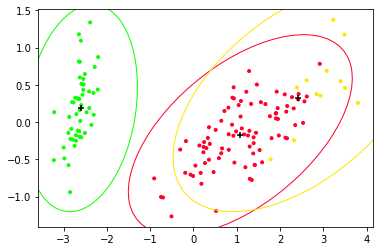

In [18]:
# results
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, vb_opt_dict, e_z_opt, fig)

# Set up linear response derivatives

In [19]:
# set up objective functions

# this just returns the KL at epsilon = 0 
# (no perturbation)
# NOTE this function doesn't actually depend on epsilon
# we can do this and set log_phi later because 
# the perturbation is multiplicative 
# (so the hessian at epsilon = 0 does not depend on the perturbation)
get_vb_loss = paragami.FlattenFunctionInput(
    lambda params, epsilon: gmm_lib.get_kl(features, 
                                            params,
                                            prior_params_dict, 
                                            gh_loc,
                                            gh_weights),
    argnums=0, patterns=vb_params_paragami, free=True)


# this is just a place holder for a null perturbation
# will set this properly later
hyper_par_objective_fun = lambda params, epsilon: 0.

In [20]:
# set up linear approximation class
epsilon0 = np.array([0.])

epsilon_sens = \
    HyperparameterSensitivityLinearApproximation(
        objective_fun = get_vb_loss, 
        opt_par_value = vb_opt, 
        hyper_par_value0 = epsilon0, 
        hyper_par_objective_fun = hyper_par_objective_fun)

Compiling ...
Compile time: 81.9434sec



# Compute influence function

In [21]:
influence_operator = gmm_influence_lib.InfluenceOperator(vb_opt, 
                           vb_params_paragami, 
                           epsilon_sens.hessian_solver,
                           prior_params_dict['alpha'])

In [22]:
logit_v_grid = np.linspace(-10, 10, 200)
v_grid = sp.special.expit(logit_v_grid)

In [23]:
influence_free_params = influence_operator.get_influence(logit_v_grid)

In [24]:
def g(vb_free_params, vb_params_paragami): 
    e_z = gmm_lib.get_optimal_z_from_vb_params_dict(features, 
                                      vb_params_paragami.fold(vb_free_params, free = True), 
                                      gh_loc, gh_weights)
    
    return cluster_lib.get_e_num_clusters_from_ez(e_z)

In [25]:
get_grad_g = jax.jacobian(g, argnums = 0)
grad_g = get_grad_g(vb_opt, vb_params_paragami)

In [26]:
influence = np.dot(grad_g, influence_free_params)

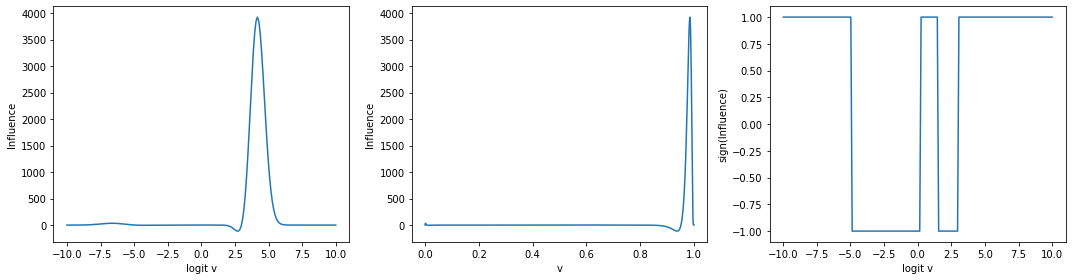

In [27]:
fig, ax = plt.subplots(1, 3, figsize = (15, 4)) 
ax[0].plot(logit_v_grid, influence)
ax[0].set_xlabel('logit v')
ax[0].set_ylabel('Influence')

ax[1].plot(v_grid, influence)
ax[1].set_xlabel('v')
ax[1].set_ylabel('Influence')

ax[2].plot(logit_v_grid, np.sign(influence))
ax[2].set_xlabel('logit v')
ax[2].set_ylabel('sign(Influence)')

fig.tight_layout()

In [28]:
log_qk = influence_operator.get_log_qk(logit_v_grid, influence_operator.vb_opt)

In [29]:
log_prior = gmm_influence_lib.get_log_logitstick_prior(logit_v_grid, prior_params_dict['alpha'])

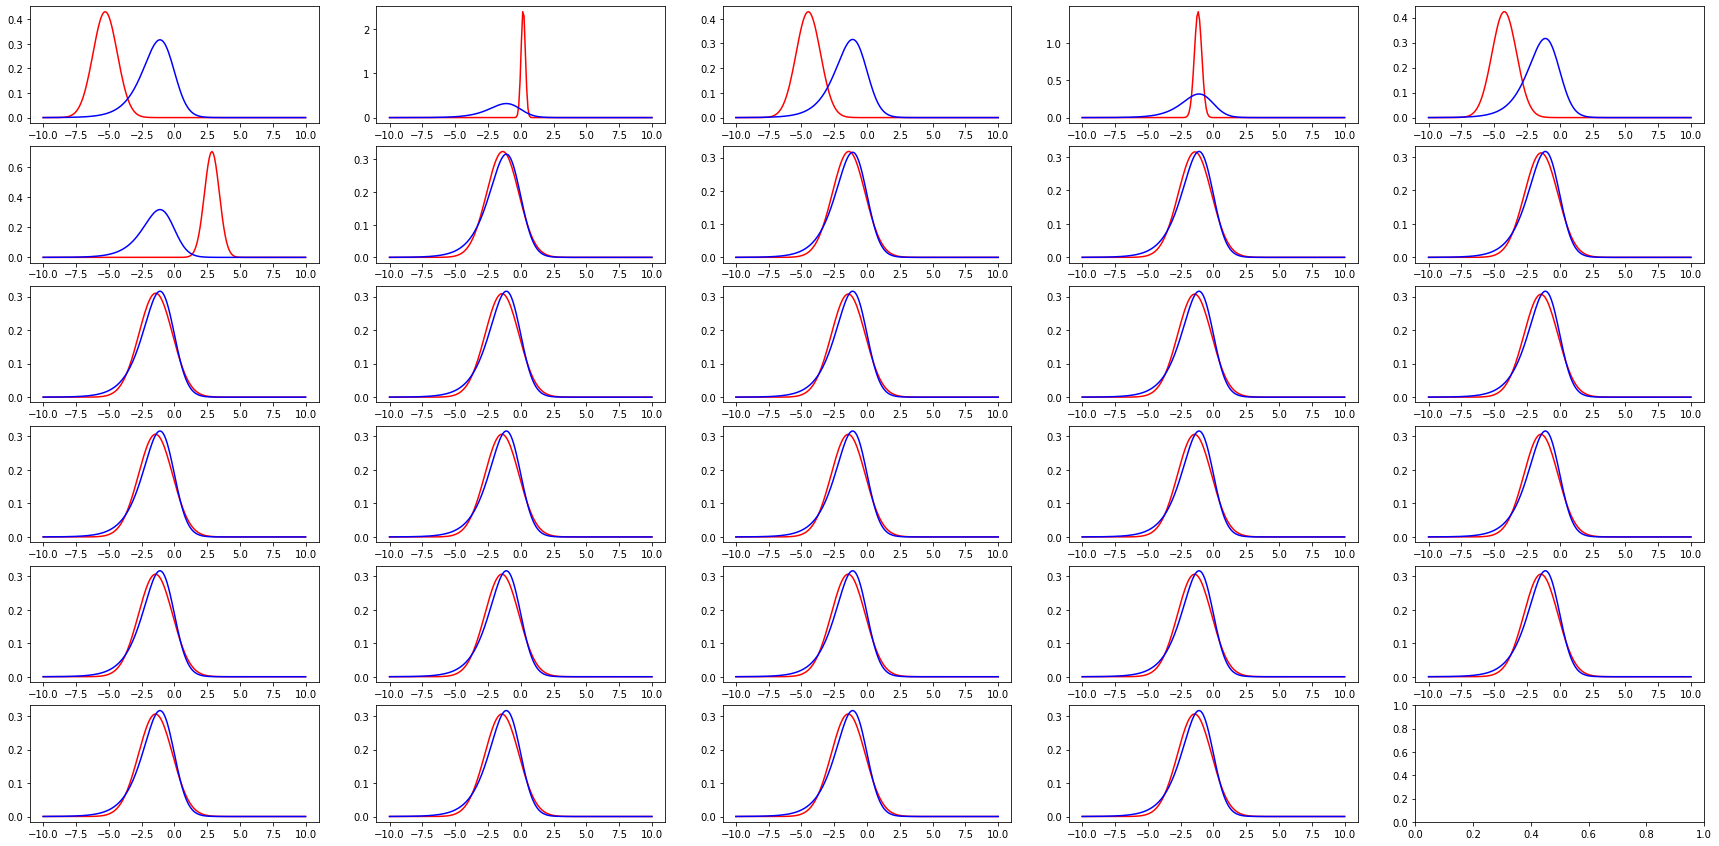

In [30]:
fig, ax = plt.subplots(6, 5, figsize = (30, 15)) 

for k in range(k_approx - 1): 
    ax[k // 5, k % 5].plot(logit_v_grid, np.exp(log_qk[k, :]), color = 'red')
    ax[k // 5, k % 5].plot(logit_v_grid, np.exp(log_prior), color = 'blue')

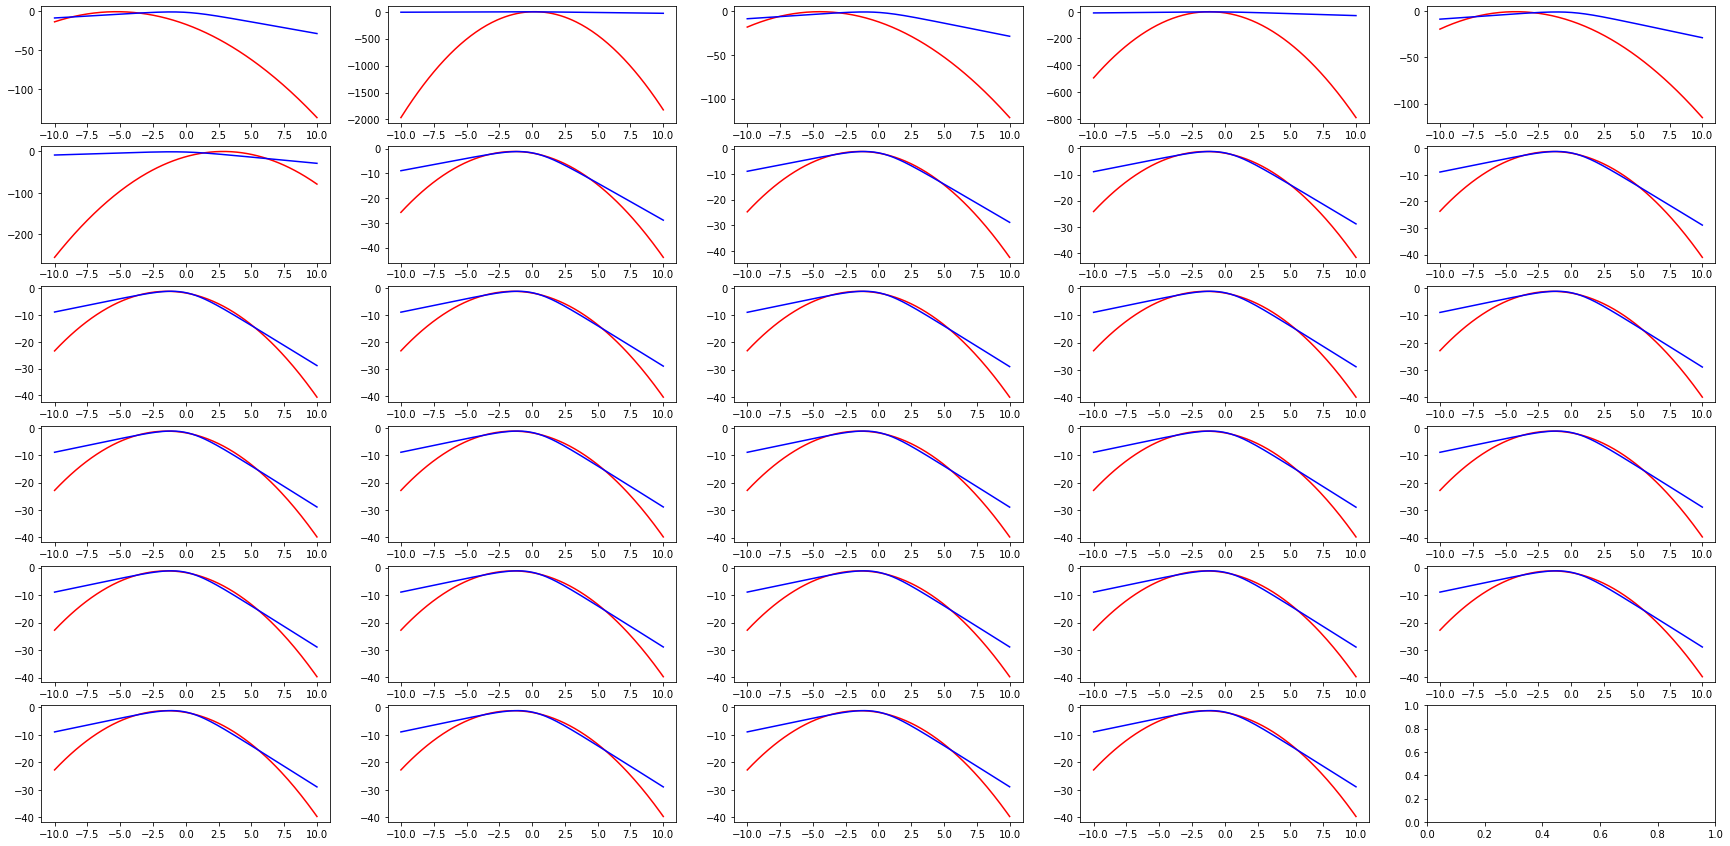

In [31]:
fig, ax = plt.subplots(6, 5, figsize = (30, 15)) 

for k in range(k_approx - 1): 
    ax[k // 5, k % 5].plot(logit_v_grid, log_qk[k, :], color = 'red')
    ax[k // 5, k % 5].plot(logit_v_grid, log_prior, color = 'blue')

# Compute worst case influence

In [32]:
# just for plotting only! 
# saves some time in computing the influence function
# by doing a setp function interpolation
def influence_fun_interp(logit_v): 
    # find index of logit_v_grid 
    # closest (on the left) to logit_v
    indx = np.searchsorted(logit_v_grid, logit_v)
    
    # return the influence function at those points
    return influence[indx]

In [33]:
# define log phi
def log_phi(logit_v):
    return(np.sign(influence_fun_interp(logit_v)))

In [34]:
prior_perturbation = func_sens_lib.PriorPerturbation(
                                alpha0 = prior_params_dict['alpha'],
                                log_phi = log_phi, 
                                logit_v_ub = 6, 
                                logit_v_lb = -6)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/scipy/integrate/quadrature.py:249: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.492416e-02
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/scipy/integrate/quadrature.py:249: AccuracyWarning: maxiter (50) exceeded. Latest difference = 8.166839e-02
  warnings.warn(


Text(0.5, 1.0, 'Priors in logit space')

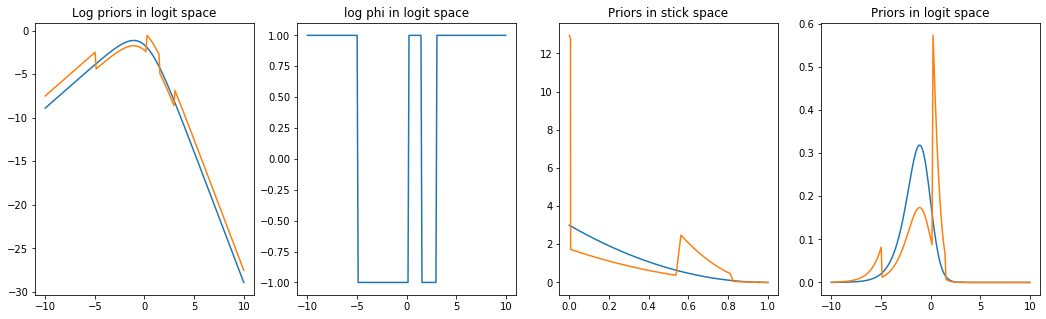

In [35]:
prior_perturbation.set_epsilon(1.0)
v_grid = sp.special.expit(logit_v_grid)

plt.figure(1, figsize=(18, 5))

plt.subplot(141)
plt.plot(logit_v_grid, prior_perturbation.get_log_p0_logit(logit_v_grid))
plt.plot(logit_v_grid, prior_perturbation.get_log_pc_logit(logit_v_grid))
plt.title('Log priors in logit space')

plt.subplot(142)
plt.plot(logit_v_grid, prior_perturbation.log_phi(logit_v_grid))
plt.title('log phi in logit space')

plt.subplot(143)
plt.plot(v_grid, np.exp(prior_perturbation.get_log_p0(v_grid)))
plt.plot(v_grid, np.exp(prior_perturbation.get_log_pc(v_grid)))
plt.title('Priors in stick space')

plt.subplot(144)
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_p0_logit(logit_v_grid)))
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_pc_logit(logit_v_grid)))
plt.title('Priors in logit space')


# Set up prior perturbation

In [37]:
worst_case_pert = gmm_influence_lib.WorstCasePerturbation(\
                            lambda logit_v : np.dot(grad_g,
                                                    influence_operator.get_influence(logit_v)))

In [38]:
def get_e_log_perturbation(means, infos, epsilon): 
    return epsilon * worst_case_pert.get_e_log_linf_perturbation(means, infos)

In [39]:
def _hyper_par_objective_fun(params, epsilon): 
    
    means = params['stick_params']['stick_means']
    infos = params['stick_params']['stick_infos']
    
    return - get_e_log_perturbation(means, infos, epsilon)

# the terms of the KL objective that depend on epsilon 
hyper_par_objective_fun = paragami.FlattenFunctionInput(_hyper_par_objective_fun,
                                                        argnums=0, 
                                                        patterns=vb_params_paragami,
                                                        free=True)

# get derivative for prior perturbation

In [40]:
epsilon_sens._set_cross_hess(hyper_par_objective_fun)
epsilon_sens._set_dinput_dhyper()

In [41]:
epsilon = 1.0 
print('Epsilon: ', epsilon)

vb_pert_pred = epsilon_sens.predict_opt_par_from_hyper_par(epsilon)

print('Predicted differences: ', np.linalg.norm(vb_pert_pred - vb_opt))

Epsilon:  1.0
Predicted differences:  3.718495350780332


In [42]:
vb_pert_pred_dict = vb_params_paragami.fold(vb_pert_pred, free = True)
e_z_pert_pred = gmm_lib.get_optimal_z_from_vb_params_dict(
    features, vb_pert_pred_dict, gh_loc, gh_weights)

# Fit with perturbation

In [43]:
new_init_dict = deepcopy(vb_opt_dict)
new_init_free = vb_params_paragami.flatten(new_init_dict, free = True)

In [44]:
vb_pert_dict, e_z_pert = cavi_lib.run_cavi(
                            features, deepcopy(new_init_dict),
                            vb_params_paragami, prior_params_dict,
                            gh_loc, gh_weights,
                            e_log_phi = lambda means, infos : \
                                           worst_case_pert.get_e_log_linf_perturbation(means, infos) * \
                                           epsilon, 
                            debug = False)

vb_pert_opt = vb_params_paragami.flatten(vb_pert_dict, free = True)

Compiling CAVI update functions ... 
CAVI compile time: 5.97sec

Running CAVI ... 
done. num iterations = 218
stick_time: 3.14sec
cluster_time: 0.137sec
e_z_time: 0.0959sec
**CAVI time: 3.64sec**


In [45]:
vb_pert_opt_dict = vb_params_paragami.fold(vb_pert_opt, free = True)
e_z_pert_opt = gmm_lib.get_optimal_z_from_vb_params_dict(features, vb_pert_opt_dict, gh_loc, gh_weights)

Epsilon: 1.0


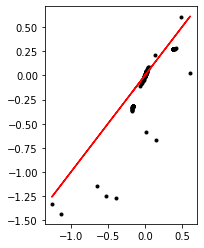

In [46]:
print('Epsilon:', epsilon)

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(vb_pert_opt - vb_opt, vb_pert_pred - vb_opt, 'k.')
plt.plot(vb_pert_opt - vb_opt, vb_pert_opt - vb_opt, 'r')


In [61]:
print('original expected number of clusters: ',
    g(vb_opt, vb_params_paragami))

print('perturbed expected number of clusters: ',
    g(vb_pert_opt, vb_params_paragami))

print('predicted expected number of clusters: ',
    g(vb_pert_pred, vb_params_paragami))

original expected number of clusters:  3.8500046528046994
perturbed expected number of clusters:  3.375724549858763
predicted expected number of clusters:  3.253893648513433


# Predict for a range of perturbation

In [49]:
# The range of epsilons we shall consider
epsilon_vec = np.linspace(0, 1, 12) ** 2 # Square to get more points close to 0
print(epsilon_vec)

[0.         0.00826446 0.03305785 0.07438017 0.1322314  0.20661157
 0.29752066 0.40495868 0.52892562 0.66942149 0.82644628 1.        ]


In [50]:
def refit_with_epsilon(epsilon, new_init_dict):
    # sets new epsilon, returns new vb optimum

    vb_pert_dict, e_z_pert = cavi_lib.run_cavi(features, deepcopy(new_init_dict),
                                        vb_params_paragami, prior_params_dict,
                                        gh_loc, gh_weights,
                                        e_log_phi = lambda means, infos : \
                                           worst_case_pert.get_e_log_linf_perturbation(means, infos) * \
                                           epsilon, 
                                       debug = False)
    
    return vb_params_paragami.flatten(vb_pert_dict, free = True)

In [51]:
best_param_phi_array = []
best_param_phi_pred_array = []

In [52]:
vb_pert_opt_array = []
vb_pert_pred_array = []


for i in range(len(epsilon_vec)): 
    epsilon = epsilon_vec[i]
    print('\n\nEpsilon: ', epsilon)
    
    # get linear predictions
    vb_pert_pred = \
        epsilon_sens.predict_opt_par_from_hyper_par(epsilon)

    print('Predicted differences: ', np.linalg.norm(vb_pert_pred - vb_opt))
    
    # Then fit with the perturbation.
    vb_pert_opt = refit_with_epsilon(epsilon, new_init_dict)
    
    print('Done. ')

    print('Predicted differences: ', np.linalg.norm(vb_pert_pred - vb_opt))
    print('Actual differences:',
          np.linalg.norm(vb_pert_opt - vb_opt))
    
    # save results: 
    vb_pert_opt_array.append(vb_pert_opt)
    vb_pert_pred_array.append(vb_pert_pred)
    




Epsilon:  0.0
Predicted differences:  0.0
Compiling CAVI update functions ... 
CAVI compile time: 5.85sec

Running CAVI ... 
done. num iterations = 2
stick_time: 0.0356sec
cluster_time: 0.00191sec
e_z_time: 0.00224sec
**CAVI time: 0.045sec**
Done. 
Predicted differences:  0.0
Actual differences: 0.00995480449972733


Epsilon:  0.008264462809917356
Predicted differences:  0.030731366535374643
Compiling CAVI update functions ... 
CAVI compile time: 5.86sec

Running CAVI ... 
done. num iterations = 8
stick_time: 0.122sec
cluster_time: 0.00595sec
e_z_time: 0.00462sec
**CAVI time: 0.145sec**
Done. 
Predicted differences:  0.030731366535374643
Actual differences: 0.025597806671109086


Epsilon:  0.03305785123966942
Predicted differences:  0.12292546614149845
Compiling CAVI update functions ... 
CAVI compile time: 5.85sec

Running CAVI ... 
done. num iterations = 26
stick_time: 0.351sec
cluster_time: 0.0171sec
e_z_time: 0.0129sec
**CAVI time: 0.416sec**
Done. 
Predicted differences:  0.1229

# Expected number of clusters

In [53]:
import numpy as onp

In [58]:
lr_e_num_clusters_vec = onp.zeros(len(epsilon_vec))
refit_e_num_clusters_vec = onp.zeros(len(epsilon_vec))

for i in tqdm(range(len(epsilon_vec))): 
    # number of clusters as predicted by linear response
    lr_e_num_clusters_vec[i] = g(vb_pert_pred_array[i],
                                 vb_params_paragami)
    
    # number of clusters after refitting 
    refit_e_num_clusters_vec[i] = g(vb_pert_opt_array[i],
                                    vb_params_paragami)
    


100%|██████████| 12/12 [00:22<00:00,  1.91s/it]


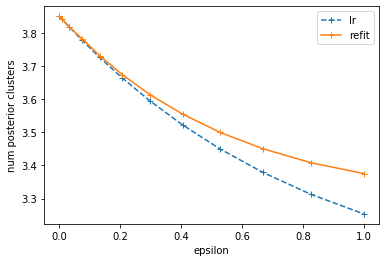

In [59]:
plt.plot(epsilon_vec, lr_e_num_clusters_vec, '+--')
plt.plot(epsilon_vec, refit_e_num_clusters_vec, '+-')

plt.xlabel('epsilon')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))
